# 1. Imports

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import pickle
import shap
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# 2. Definições

In [75]:
IMAGES_PATH = "../reports/figures/"
PATH_INPUT_DATASET = "../data/processed/internacoes_processado.csv"
PATH_BEST_MODELS = "./models/best_models.pkl"

style_dict = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.titlesize": "large",
    'text.color': '.25',
}

sns.set_theme(
    context="paper",
    style="ticks",
    palette="hls",
    rc=style_dict
)

validacao_metrica_mapping = {
    'Acurácia' : 'Sem Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'Precisão': 'Sem Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'Recall': 'Sem Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'AUC': 'Sem Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'Acurácia_Tunagem': 'Com Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'Precisão_Tunagem': 'Com Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'Recall_Tunagem': 'Com Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'AUC_Tunagem': 'Com Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'Acurácia_Teste': 'Houldout dataset',
    'Precisão_Teste': 'Houldout dataset',
    'Recall_Teste': 'Houldout dataset',
    'AUC_Teste': 'Houldout dataset'
}

# 3. Funções de apoio

In [76]:
def salvar_figura(fig, fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH + f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    print(f'Salvando figura {fig_id}...')
    fig.savefig(path, format=fig_extension, dpi=resolution)

def obter_nomes_colunas_por_tipo(df, numeric=False):
    if numeric:
        return list(df.select_dtypes(include=['int64', 'float64']).columns)
    else:
        return list(df.select_dtypes(include=['object']).columns)

def plotar_features_categoricas(df, target_column, categorical_features):
    for feature in categorical_features:
        sns.countplot(x=feature, data=df, hue=target_column)
        plt.show()
        plt.clf()
    plt.tight_layout()

def melt_results_df(results_df):
    df = pd.melt(results_df, id_vars="Model", value_vars=results_df.columns[1:])
    
    df['Validacao'] = df['variable'].map(validacao_metrica_mapping)
    df['Metrica'] = df['variable'].str.split('_').str[0]
    df['Valor'] = df['value']

    df = df.drop(columns=['variable', 'value'])

    return df
    

# 4. Validação

In [77]:
input = pd.read_csv('model_selection_results.csv')
results = melt_results_df(input)

results

,Model,Validacao,Metrica,Valor
0,RandomForest,Sem Tunagem de Hiper-parâmetros\n(dataset de t...,Acurácia,0.585656
1,GradientBoosting,Sem Tunagem de Hiper-parâmetros\n(dataset de t...,Acurácia,0.602459
2,LogisticRegression,Sem Tunagem de Hiper-parâmetros\n(dataset de t...,Acurácia,0.606148
3,XGB,Sem Tunagem de Hiper-parâmetros\n(dataset de t...,Acurácia,0.579918
4,LGBM,Sem Tunagem de Hiper-parâmetros\n(dataset de t...,Acurácia,0.584836
...,...,...,...,...
79,LogisticRegression,Houldout dataset,AUC,0.665717
80,XGB,Houldout dataset,AUC,0.831506
81,LGBM,Houldout dataset,AUC,0.839301
82,SVM,Houldout dataset,AUC,0.667489


Salvando figura comparacao_metricas_por_modelo...


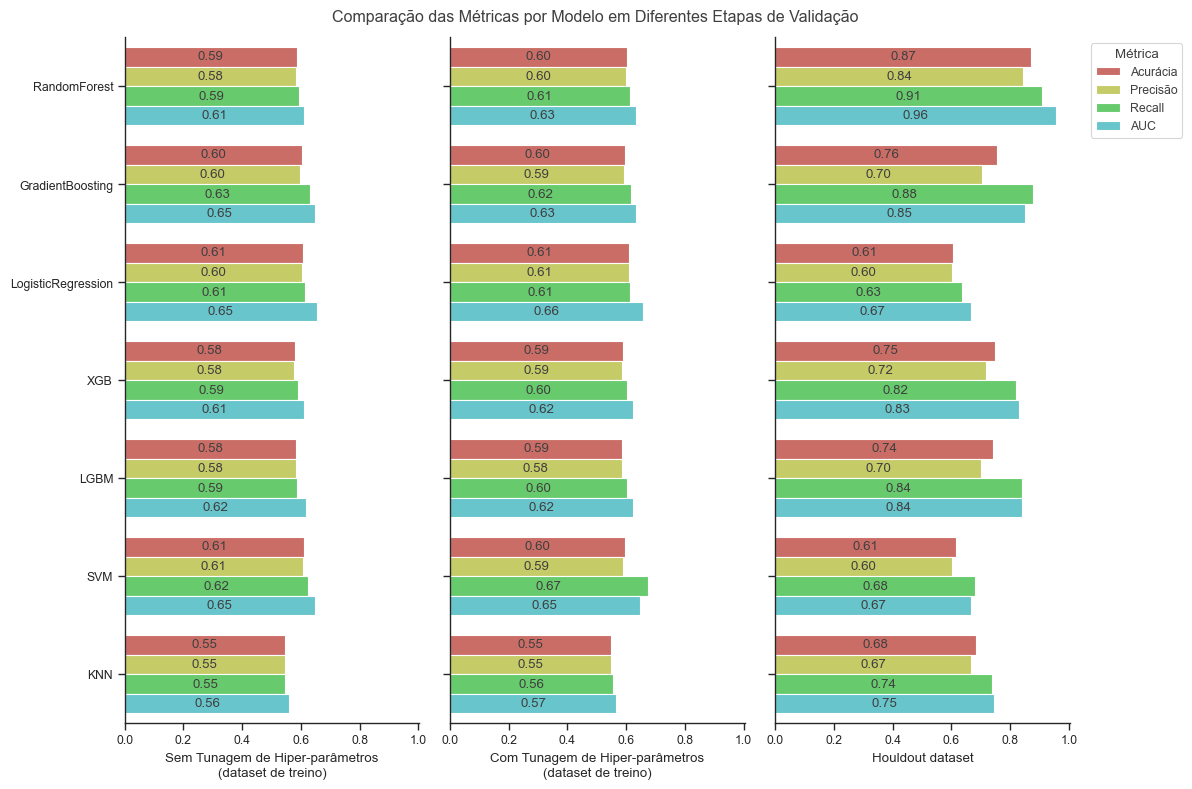

In [120]:
fig, axes = plt.subplots(1, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for tipo_validacao, ax in zip(results["Validacao"].unique(), axes):

    to_plot = results[results["Validacao"] == tipo_validacao]
    
    bars = sns.barplot(x="Valor", y="Model", hue="Metrica", data=to_plot, ax=ax, ci=95, orient='h')
    ax.set_xlabel(tipo_validacao)
    ax.set_ylabel("")
    ax.legend().remove()

    for bar in bars.patches:
        width = bar.get_width()
        ax.text(width / 2, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', ha='center', va='center')


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, title="Métrica");

fig.suptitle("Comparação das Métricas por Modelo em Diferentes Etapas de Validação")
salvar_figura(fig, "comparacao_metricas_por_modelo")

Salvando figura variacao_metricas_teste_por_modelo...


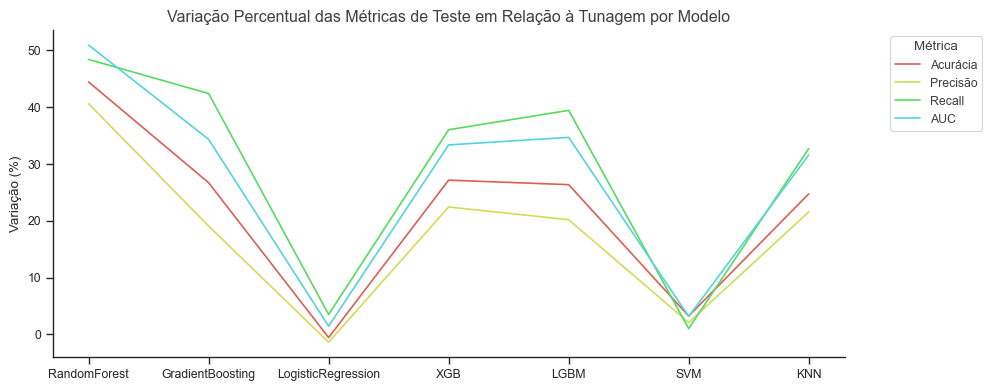

In [122]:
metricas = [
    "Acurácia",
    "Precisão",
    "Recall",
    "AUC"
]

for metrica in metricas:
    input[metrica] = (input[f'{metrica}_Teste'] / input[f'{metrica}_Tunagem'] - 1) * 100

melted = pd.melt(input, id_vars=['Model'], value_vars=[metrica for metrica in metricas], value_name="Valor", var_name="Métrica")

fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(data=melted, x='Model', y='Valor', hue='Métrica', ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Métrica')
ax.set_ylabel('Variação (%)')
ax.set_xlabel('')
ax.set_title("Variação Percentual das Métricas de Teste em Relação à Tunagem por Modelo");

salvar_figura(fig, "variacao_metricas_teste_por_modelo")

# 5. Análise de Feature Importance

In [168]:
with open(PATH_BEST_MODELS, 'rb') as f:
    best_models = pickle.load(f)

preprocessor = best_models['RandomForest']['preprocessor']
model = best_models['RandomForest']['model']


df = pd.read_csv(PATH_INPUT_DATASET)

X = df.drop("reinternacao", axis=1)
y = df["reinternacao"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = undersampler.fit_resample(X_test, y_test)

X_train_resampled = preprocessor.transform(X_train_resampled)
X_test_resampled = preprocessor.transform(X_test_resampled)

features_names = preprocessor.get_feature_names_out()


In [169]:
explainer = shap.Explainer(model, X_train_resampled)
shap_values = explainer(X_test_resampled, check_additivity=False)

100%|===================| 1672/1676 [01:00<00:00]        